# Does Your Skillset Match Up To Current Available Jobs?
To see if we have the skills employers are looking for in the data science profession, we decided to look from the employer vantage point by analyzing the data science jobs available on indeed.com. In this approach, we scraped job descriptions (Beautiful Soup) for all data science jobs available on indeed.com.  We processed those job desciptions through a TSNE Visualizer in order to identify evident clusters within the dataset and ran a TF-IDF Vectorizer to see the most common words used in each cluster. Then we processed those job descriptions into a weighted word matrix to create a job summary from all the available job descriptions.

# But First...

In [1]:
import requests
import bs4
import re
import math
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup

plt.rcParams['figure.figsize'] = [18, 12]

# Retrieve Job Description Data from Indeed.com

First, in order to ignore fuzzy matches from our job searches, we only focused on jobs that had the following word phrases in its job title:
1. data scientist
2. quantitative analyst
3. statistician
4. data analyst
5. research scientist
6. machine learning engineer
7. data engineer

In [2]:
base_url = ''

# Declare job titles to search on indeed.com
titles = [{
    'title': 'data scientist',
    'urltitle': 'data+scientist'
}, {
    'title': 'quantitative analyst',
    'urltitle': 'quantitative+analyst'
}, {
    'title': 'statistician',
    'urltitle': 'statistician'
}, {
    'title': 'data analyst',
    'urltitle': 'data+analyst'
}, {
    'title': 'research scientist',
    'urltitle': 'research+scientist'
}, {
    'title': 'machine learning engineer',
    'urltitle': 'machine+learning+engineer'
}, {
    'title': 'data engineer',
    'urltitle': 'data+engineer'
}]

## Retireve Job Descriptions from provided job urls

In [4]:
# Function to retireve Job Description from provided job url
def storedescription(term, url):
    try:
        r = requests.get('https://www.indeed.com'+url)
        soup = BeautifulSoup(r.text, 'html.parser')
        description = soup.find('div', id="jobDescriptionText").get_text()
        jobdescription.append(description)
    except Exception as e:
        print(f'description error: {e}')
        jobdescription.append("")

In [ ]:
# Lists to hold retrieved values
jobtitles = []
urls = []
jobclass = []
jobdescription = []

# search by job title
for term in titles:
    startlen = len(urls)
    try:
        r = requests.get('https://www.indeed.com/jobs?q={}&sort=date&limit=50'.format(term['urltitle']))
        #r = requests.get('https://www.indeed.com/jobs?q={}&l=New+York%2C+NY&sort=date&limit=50'.format(term['urltitle']))
        soup = BeautifulSoup(r.text, 'html.parser')
        count_str = soup.find('div', id="searchCountPages").get_text()
        max_results = int(count_str.split()[3].replace(',', ''))

        # calculate how many pages we need to query
        max_results = math.ceil(max_results/50)
        time.sleep(1)
    except Exception as e:
        print(f'title error: {e}') 

    print('Querying {} pages for {}'.format(max_results, term['title']))
    for x in range(0, max_results):

        try:
            split = '&start='+format(x*50)
            html = requests.get('https://www.indeed.com/jobs?q={}&sort=date&limit=50+{}'.format(term['urltitle'], split))
            #html = requests.get('https://www.indeed.com/jobs?q={}&l=New+York%2C+NY&sort=date&limit=50+{}'.format(term['urltitle'], split))
            soup = BeautifulSoup(html.text, 'html.parser')
            for link in soup.findAll('a'):
                try:
                    # only retireve urls from matching titles
                    if term['title'].lower() in link.attrs['title'].lower():
                        jobtitles.append(link.attrs['title'])
                        urls.append(link.attrs['href'])
                        jobclass.append(term['title'])
                        storedescription(term['title'], link.attrs['href'])
                        
                except Exception as e:
                    print(f'{x} attribute link error: {e}') 
            time.sleep(1)
        except Exception as e:
            print(f'link error: {e}')

    print('.. found {} results for {}'.format(len(urls)-startlen, term['title']))

In [6]:
print(len(jobtitles))
print(len(urls))
print(len(jobclass))
print(len(jobdescription))

3013
3013
3013
3013


In [7]:
df = pd.DataFrame({'title': jobtitles, 'jobclass': jobclass, 'url': urls, 'jobdescription': jobdescription})
#df = pd.DataFrame({'jobdescription': jobdescription})

In [8]:
df.to_csv("../exported_data/indeed_data_raw.csv")

# Process Job Decsription Data

In [2]:
raw_df = pd.read_csv("../exported_data/indeed_data_raw.csv")
del raw_df["Unnamed: 0"]

jobtitles_raw = raw_df.title.astype(str).values.tolist()
jobclass_raw = raw_df.jobclass.astype(str).values.tolist()
urls_raw = raw_df.url.astype(str).values.tolist()
jobdescription_raw = raw_df.jobdescription.astype(str).values.tolist()

print("Jobtitles: " + str(len(jobtitles_raw)))
print("URLS: " + str(len(urls_raw)))
print("Job Classes: " + str(len(jobclass_raw)))
print("Job Descriptions: " + str(len(jobdescription_raw)))

Jobtitles: 3013
URLS: 3013
Job Classes: 3013
Job Descriptions: 3013


In [3]:
raw_df.dtypes

title             object
jobclass          object
url               object
jobdescription    object
dtype: object

In [4]:
raw_df['title'].value_counts()

Data Scientist                                             795
Economy Hotel Data Analyst/Operations Support              241
Data Analyst - contractor                                  241
Data Analyst-Regional Systems Improvement Spec             241
Data Analyst III(populantion Health, SQL, Pharmacy)        196
                                                          ... 
Project Statistician                                         1
Federal - Data Analyst - SI                                  1
CMC Data Scientist, Manufacturing Sciences & Technology      1
Data Scientist, Ads Measurement                              1
QA Data Analyst                                              1
Name: title, Length: 266, dtype: int64

In [5]:
raw_df['jobclass'].value_counts()

data scientist               1364
data analyst                 1100
research scientist            234
statistician                  167
machine learning engineer     106
quantitative analyst           32
data engineer                  10
Name: jobclass, dtype: int64

In [6]:
def preprocess(line):
    line = line.replace('\n', ' ') # newlines
    line = line.replace('(', ' ')
    line = line.replace(')', ' ')
    line = line.replace('[', ' ') 
    line = line.replace(']', ' ')
#     line = line.replace('.', ' ')
#     line = line.replace(',', ' ')
#     line = line.replace('&', ' ')
#     line = line.replace(' - ', ' ')
    line = line.replace(':', ' ') # We dont need summaries, just give me tokens
    line= line.replace('\t', ' ') #tabs
    
    # converts line endings in a way that stops the accidental camelcasing
    # but leaves terms like SAP intact
    line= re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', line)
    
    # regex to address the issue of text continuing directly after a period
    # instead of a space
    line = re.sub(r'\.(?! )', '. ', re.sub(r' +', ' ', line))
    return line

In [7]:
raw_df["jobdescription"][10]

"Please make sure to read the job posting in its entirety as it reflects both the University roles and responsibilities, followed by the specific description.\nDepartment\n2012223 Medicine-Genetic Medicine\nAbout the Unit\nJob Family\nResearch\nResponsible for all aspects of research projects and research facilities. Plans and conducts clinical and non-clinical research; facilitates and monitors daily activities of clinical trials or research projects. Directs engineering and technical support activities to develop and maintain tools and computational methods needed to gather and analyze data.\nCareer Track and Job Level\nData Science\nConducts data investigation, including data wrangling, cleaning, sampling, management, exploratory analysis, regression and classification, prediction, and data communication. Implements foundational concepts of data computation, such as data structure, algorithms, parallel computing, simulation, and analysis. Utilizes knowledge in game theory, statistic

In [8]:
# jobdescription = df.jobdescription
description = [preprocess(d) for d in jobdescription_raw]

len(description)

3013

In [9]:
description[10]

"Please make sure to read the job posting in its entirety as it reflects both the University roles and responsibilities, followed by the specific description. Department 2012223 Medicine-Genetic Medicine About the Unit Job Family Research Responsible for all aspects of research projects and research facilities. Plans and conducts clinical and non-clinical research; facilitates and monitors daily activities of clinical trials or research projects. Directs engineering and technical support activities to develop and maintain tools and computational methods needed to gather and analyze data. Career Track and Job Level Data Science Conducts data investigation, including data wrangling, cleaning, sampling, management, exploratory analysis, regression and classification, prediction, and data communication. Implements foundational concepts of data computation, such as data structure, algorithms, parallel computing, simulation, and analysis. Utilizes knowledge in game theory, statistical qualit

In [10]:
processed_df = pd.DataFrame({'title': jobtitles_raw, 'jobclass': jobclass_raw, 'url': urls_raw, 'jobdescription': description})
#processed_df = pd.DataFrame({'jobdescription': description})

In [11]:
processed_df.to_csv("../exported_data/indeed_data_processed.csv")

# Find Words Counts from Processed Descriptions

In [12]:
postprocessed_df = pd.read_csv("../exported_data/indeed_data_processed.csv")
del postprocessed_df["Unnamed: 0"]

jobtitles_post = postprocessed_df.title.astype(str).values.tolist()
jobclass_post = postprocessed_df.jobclass.astype(str).values.tolist()
urls_post = postprocessed_df.url.astype(str).values.tolist()
jobdescription_post = postprocessed_df.jobdescription.astype(str).values.tolist()

print("Jobtitles: " + str(len(jobtitles_post)))
print("URLS: " + str(len(urls_post)))
print("Job Classes: " + str(len(jobclass_post)))
print("Job Descriptions: " + str(len(jobdescription_post)))

Jobtitles: 3013
URLS: 3013
Job Classes: 3013
Job Descriptions: 3013


## TSNE Visualizer

The Job Descriptions were then run through a TSNE Visualizer in order to identify the amount of clusters in the data.  

/Users/budchris/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with 

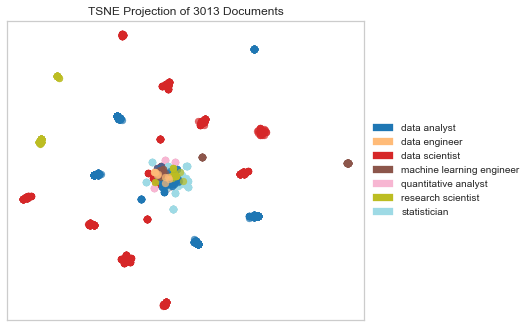

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import TSNEVisualizer

tfidf = TfidfVectorizer(stop_words='english')

X = tfidf.fit_transform(jobdescription_post)
y = jobclass_post

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(decompose_by=75, decompose='svd', colormap='tab20')
tsne.fit(X, y)
tsne.show()

In [14]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/budchris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Initializing Dictionary
d = {}
postprocessed_df["jobdescription_split"] = postprocessed_df["jobdescription"].astype(str).str.lower().str.split()

p_description = postprocessed_df["jobdescription_split"].apply(lambda x: [item for item in x if item not in stop])
p_description

0       [preventable, illnesses, still, kill, tens, th...
1       [data, scientist, pricing, analytics, team, sh...
2       [data, scientist, data, scientist, experience,...
3       [medidata, leading, digital, transformation, l...
4       [position, summary, data, scientist, participa...
                              ...                        
3008    [data, engineer, data, engineer, experience,, ...
3009    [8+, years, experience, data, engineering, 4+,...
3010    [bachelor's, degree, computer, science,, engin...
3011    [role, important, us, cca, need, enterprise, d...
3012    [department, information, technology, services...
Name: jobdescription_split, Length: 3013, dtype: object

In [16]:
# counting number of times each word comes up in list of words (in dictionary)
for word_list in p_description:
    #word_list = descr.split()
    for word in word_list: 
        d[word] = d.get(word, 0) + 1

In [17]:
word_freq = []
for key, value in d.items():
    word_freq.append((value, key))

In [18]:
word_freq.sort(reverse=True) 
print(word_freq)

[(25588, 'data'), (13917, 'experience'), (8994, 'work'), (6660, 'business'), (6443, 'team'), (6363, 'analysis'), (5428, '-'), (4859, 'required'), (4836, 'analytics'), (4591, 'knowledge'), (4523, 'including'), (4463, 'ability'), (4376, 'years'), (3404, '·'), (3326, 'statistical'), (3297, 'management'), (3289, 'new'), (3254, 'degree'), (3205, 'research'), (3166, '&'), (3161, 'job'), (3141, 'position'), (3004, 'scientist'), (2980, 'use'), (2955, 'help'), (2924, 'strong'), (2920, 'skills'), (2792, 'client'), (2663, 'regional'), (2659, 'requirements'), (2638, 'office'), (2623, 'science'), (2569, 'tools'), (2513, 'using'), (2490, 'machine'), (2455, 'must'), (2395, 'systems'), (2367, 'system'), (2349, 'provide'), (2328, 'employment'), (2325, 'improvement'), (2312, 'related'), (2258, 'develop'), (2243, 'information'), (2240, 'learning'), (2205, 'aclu'), (2141, 'leadership'), (2110, 'reporting'), (2095, 'and/or'), (2071, 'python'), (2069, 'technical'), (2067, 'across'), (2064, 'field'), (2017, 

# TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(jobdescription_raw)

In [20]:
print(vectorizer.get_feature_names())
print(X.shape)

['00', '000', '000mw', '0023r', '0034', '0051', '00pm', '01', '02', '02109', '02111', '02506', '03', '04', '05', '05375', '06', '0660', '0681', '07', '07677', '07960', '08', '09', '0abab791f984f247be6581e96addee0e', '0hhzyallbn', '10', '100', '100k', '101', '103', '103698', '104', '104k', '10546', '107', '107807', '10795', '10859293', '10870152', '10870153', '10872452', '10883477', '11', '110', '111', '11103', '112', '114', '11649', '11753', '118', '118084', '1183', '118k', '12', '120', '1200', '120k', '12205', '123', '125', '1251', '12564', '12721', '129', '12th', '13', '130', '138', '138k', '14', '140', '1400', '140146', '14155', '143', '145', '15', '150', '1500', '150k', '1529', '1530', '1550', '157', '16', '160', '1600', '1601', '165', '17', '170', '1700', '1725', '176055br', '1784', '179', '18', '1840', '185', '187', '19', '190', '19146', '1915', '1930', '1938', '1939', '1941', '1950', '1954', '1959', '1960', '1975', '1979', '1980', '1983', '1986', '1987', '1991', '1997', '1998', 

In [21]:
print(X[0,])

  (0, 9136)	0.022062665525295237
  (0, 10212)	0.022203386416519706
  (0, 7639)	0.029180669869896897
  (0, 3035)	0.01815605422752958
  (0, 4833)	0.025799905904593388
  (0, 4318)	0.02688964688506058
  (0, 6795)	0.026793966931917827
  (0, 8698)	0.026986288461880694
  (0, 6798)	0.022250754768238325
  (0, 6376)	0.02180990708866513
  (0, 8696)	0.02512047437030218
  (0, 8055)	0.022322247706895403
  (0, 2060)	0.022358194499987365
  (0, 7810)	0.022227041424645266
  (0, 7983)	0.026475597342917483
  (0, 10449)	0.0238344693453764
  (0, 2736)	0.023198149229928095
  (0, 3461)	0.017489534256197876
  (0, 5847)	0.03256862188854928
  (0, 3456)	0.018273083127879914
  (0, 3591)	0.018304532889206068
  (0, 2432)	0.060607851863251704
  (0, 9528)	0.02994220929476691
  (0, 8516)	0.03299448141311927
  (0, 118)	0.07608381405187004
  :	:
  (0, 4884)	0.09830475075847844
  (0, 9610)	0.16406554054884614
  (0, 5164)	0.029528564618035276
  (0, 2664)	0.07041817556235307
  (0, 834)	0.2501756087719411
  (0, 7570)	0.06020

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

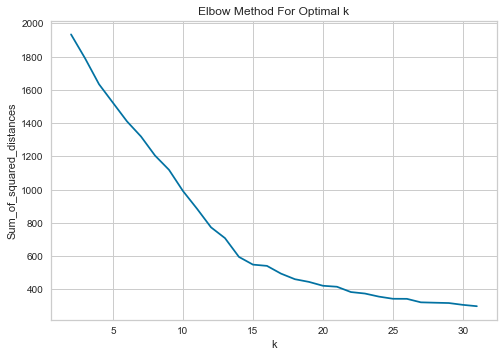

In [23]:
Sum_of_squared_distances = []
K = range(2,32)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
true_k = 23
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
indeed_cl=pd.DataFrame(list(zip(jobclass_raw,labels)),columns=['title','cluster'])
print(indeed_cl.sort_values(by=['cluster']))

               title  cluster
2135    data analyst        0
2375    data analyst        0
1851    data analyst        0
2371    data analyst        0
1855    data analyst        0
...              ...      ...
1303  data scientist       22
1313  data scientist       22
1323  data scientist       22
917   data scientist       22
890   data scientist       22

[3013 rows x 2 columns]


In [25]:
indeed_cl.groupby(['cluster'])['cluster'].count()

cluster
0     241
1     241
2     165
3     147
4     241
5     147
6     197
7     147
8     147
9     106
10    147
11    147
12    147
13     54
14     66
15     24
16     72
17      9
18     45
19     22
20     22
21    454
22     25
Name: cluster, dtype: int64

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/budchris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/budchris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Cluster: 0
Titles:
 data analyst


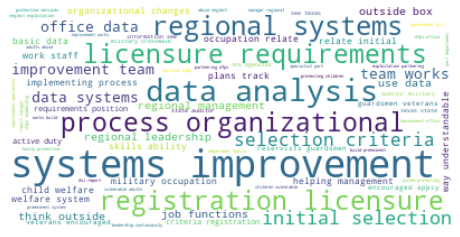

Cluster: 1
Titles:
 data analyst


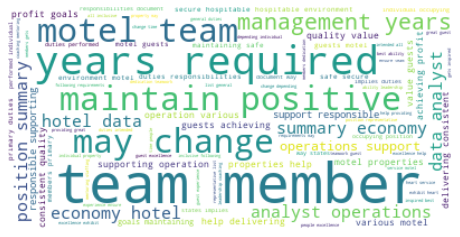

Cluster: 2
Titles:
 research scientist


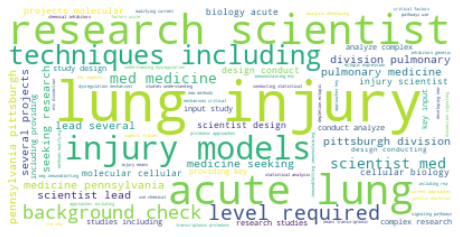

Cluster: 3
Titles:
 data scientist


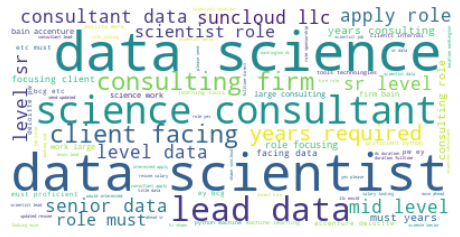

Cluster: 4
Titles:
 data analyst


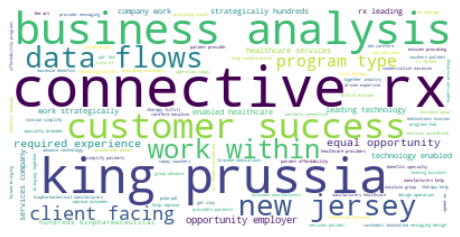

Cluster: 5
Titles:
 data scientist


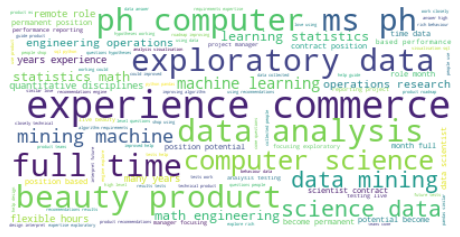

Cluster: 6
Titles:
 data analyst


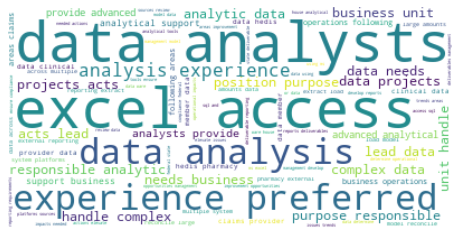

Cluster: 7
Titles:
 data scientist


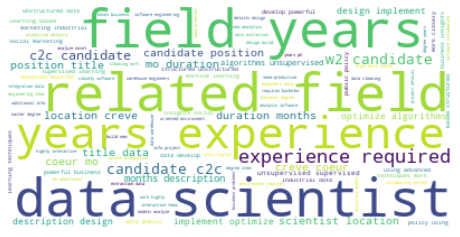

Cluster: 8
Titles:
 data scientist


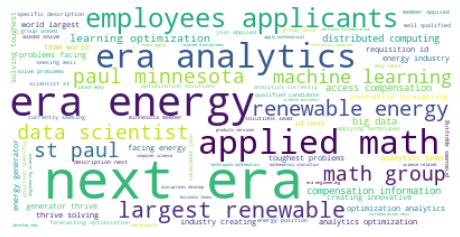

Cluster: 9
Titles:
 data scientist


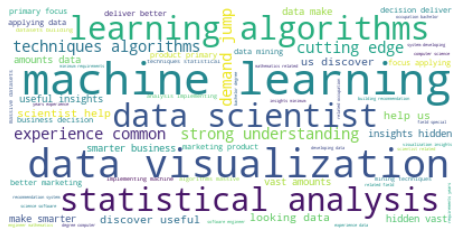

Cluster: 10
Titles:
 data scientist


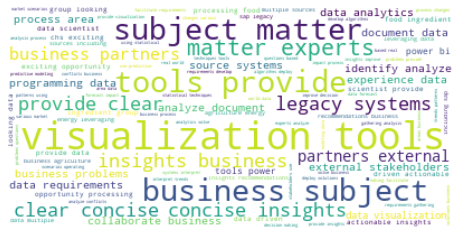

Cluster: 11
Titles:
 data scientist


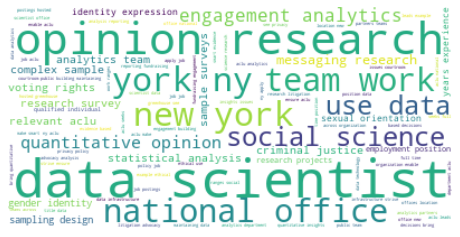

Cluster: 12
Titles:
 data scientist


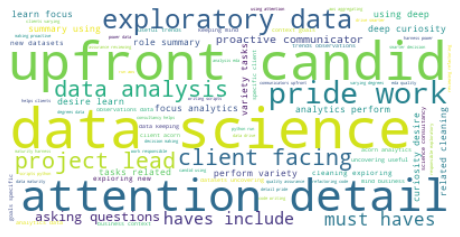

Cluster: 13
Titles:
 data analyst


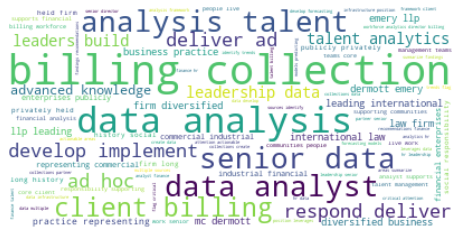

Cluster: 14
Titles:
 machine learning engineer


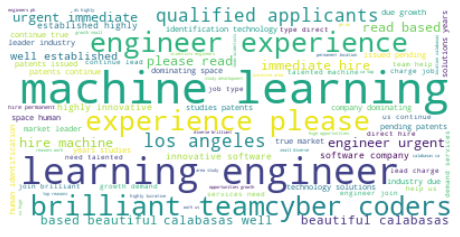

Cluster: 15
Titles:
 data scientist


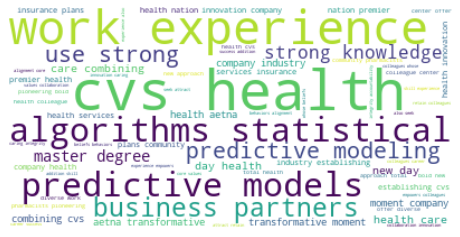

Cluster: 16
Titles:
 data scientist


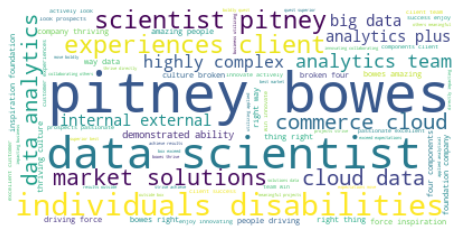

Cluster: 17
Titles:
 quantitative analyst


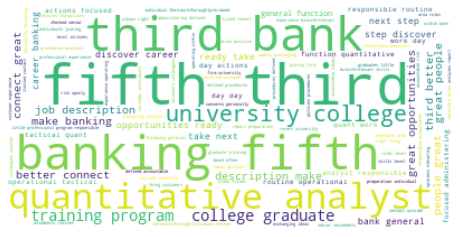

Cluster: 18
Titles:
 research scientist


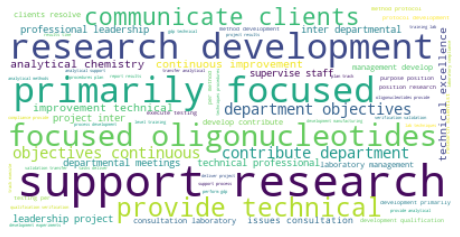

Cluster: 19
Titles:
 machine learning engineer


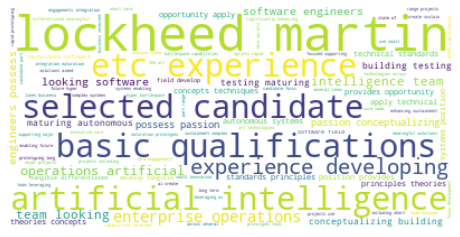

Cluster: 20
Titles:
 statistician


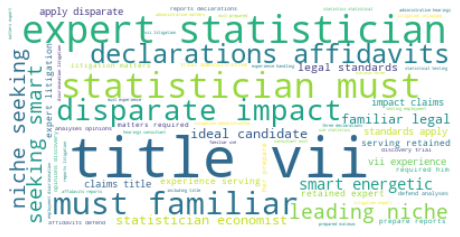

Cluster: 21
Titles:
            data scientist
      quantitative analyst
              statistician
              data analyst
        research scientist
 machine learning engineer
             data engineer


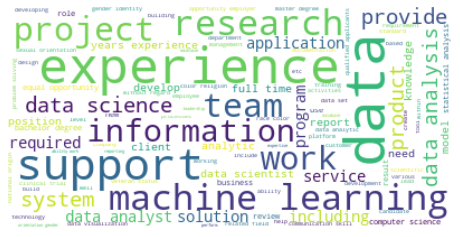

Cluster: 22
Titles:
 data scientist


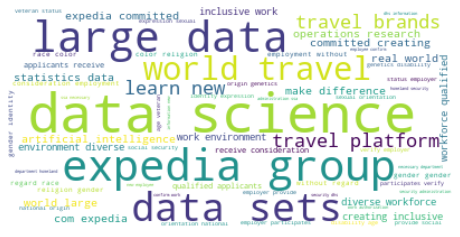

In [26]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english'))  

result={'cluster':labels,'jobclass':jobclass_post,'jobdescription':jobdescription_post}
result=pd.DataFrame(result)
for k in range(0,true_k):
# for k in range(0,1):
    s=result[result.cluster==k]
    
    text=s['jobdescription'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 

    text=' '.join([str(elem) for elem in filtered_sentence])

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles:')
    titles=indeed_cl[indeed_cl.cluster==k]['title']
    titles=titles.drop_duplicates()
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [27]:
result

cluster        jobclass  \
0          21  data scientist   
1          21  data scientist   
2          21  data scientist   
3          21  data scientist   
4          21  data scientist   
...       ...             ...   
3008       21   data engineer   
3009       21   data engineer   
3010       21   data engineer   
3011       21   data engineer   
3012       21   data engineer   

                                         jobdescription  
0     Preventable illnesses still kill tens of thous...  
1     As Data Scientist in the Pricing Analytics tea...  
2     Data Scientist If you are a Data Scientist wit...  
3     Medidata is leading the digital transformation...  
4     POSITION SUMMARY The Data Scientist participat...  
...                                                 ...  
3008  Data Engineer If you are a Data Engineer with ...  
3009  8+ Years of experience with data engineering 4...  
3010  Bachelor's degree in Computer Science, Enginee...  
3011  Why This Role is Important to Us CCA is in nee...  
3012  Department Information Technology Services Equ...  

[3013 rows x 3 columns]

# Generating Summaries from Clusters

In [28]:
import pandas as pd
import numpy as np
import datetime
import re
from tqdm import tqdm

# preprocessing
corpus = result
corpus["cluster"] = corpus.cluster.astype(str)
corpus["jobclass"] = corpus.jobclass.astype(str)
corpus["jobdescription"] = corpus.jobdescription.astype(str)
corpus = corpus.applymap(lambda x: x.strip())

import string
def remove_weird_letters(x):
    new_string = ""
    accepted_char = list(string.ascii_lowercase) + list(string.ascii_uppercase) + list(string.punctuation) + list(" ")
    
    for letter in x:
        for char in accepted_char:
            if char in letter:
                new_string = new_string + char
                break
    return new_string

corpus["Summary"] = corpus["jobdescription"].apply(lambda x: remove_weird_letters(x))

corpus.head(5)

cluster        jobclass                                     jobdescription  \
0      21  data scientist  Preventable illnesses still kill tens of thous...   
1      21  data scientist  As Data Scientist in the Pricing Analytics tea...   
2      21  data scientist  Data Scientist If you are a Data Scientist wit...   
3      21  data scientist  Medidata is leading the digital transformation...   
4      21  data scientist  POSITION SUMMARY The Data Scientist participat...   

                                             Summary  
0  Preventable illnesses still kill tens of thous...  
1  As Data Scientist in the Pricing Analytics tea...  
2  Data Scientist If you are a Data Scientist wit...  
3  Medidata is leading the digital transformation...  
4  POSITION SUMMARY The Data Scientist participat...

## Next, we tokenize using nltk and apply two sklearn transformers to create a spare weighted word matrix.

In [29]:
import nltk
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer #acts like a model pretty much

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens
# initialize count vectorizer object
vect = CountVectorizer(tokenizer=tokenize)
X = vect.fit_transform(corpus["Summary"]) # [] needs to be wrapped around the string to make it a "document" if you select single element
vect.vocabulary_

from sklearn.feature_extraction.text import TfidfTransformer

# initialize tf-idf transformer object
transformer = TfidfTransformer(smooth_idf=False)
tfidf_X = transformer.fit_transform(X)

print('done')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/budchris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


done


## Visualize PCA

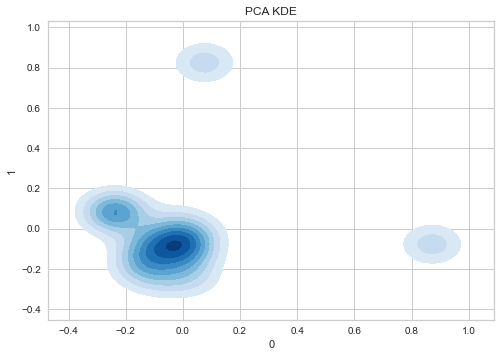

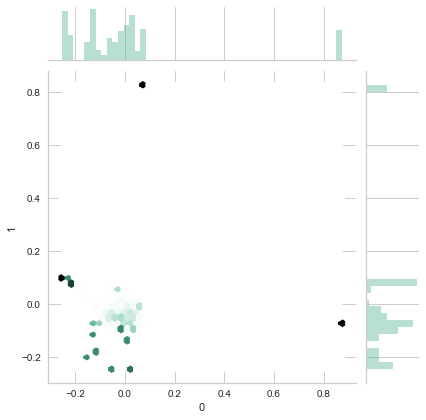

In [30]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
clust_df = pd.DataFrame(data=tfidf_X.toarray()) 
clust_df.columns = vect.vocabulary_

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(clust_df) #replace with cosine or clust_df

PCA_components = pd.DataFrame(principalComponents)
PCA_components["cluster"] = corpus["cluster"]
PCA_components["jobclass"] = corpus["jobclass"]
PCA_components["Summary"] = corpus["Summary"]
PCA_components["Size"] = 1

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.kdeplot(PCA_components[0], PCA_components[1], shade=True, cmap = 'Blues',shade_lowest=False).set(title="PCA KDE")
ax = sns.jointplot(PCA_components[0], PCA_components[1], kind="hex", color="#4CB391")

In [31]:
import time
import gensim
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, WordEmbeddingSimilarityIndex
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix
fasttext = api.load('fasttext-wiki-news-subwords-300')

In [32]:
# Create a soft cosine matrix
termsim_index = WordEmbeddingSimilarityIndex(fasttext.wv)

dictionary = Dictionary([simple_preprocess(doc) for doc in corpus["Summary"]]) 
bow_corpus = [dictionary.doc2bow(simple_preprocess(document)) for document in corpus["Summary"]]

similarity_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary)
docsim_index = SoftCosineSimilarity(bow_corpus, similarity_matrix)#, num_best=10)

sims = docsim_index[bow_corpus]
cosine = pd.DataFrame(data=sims)
cosine = cosine.applymap(lambda x: round(x,4))

print(cosine.iloc[:5,:5])

/Users/budchris/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


        0       1       2       3       4
0  1.0000  0.8689  0.8151  0.8866  0.8858
1  0.8689  1.0000  0.7862  0.8880  0.8918
2  0.8151  0.7862  1.0000  0.8116  0.8184
3  0.8866  0.8880  0.8116  1.0000  0.9128
4  0.8858  0.8918  0.8184  0.9128  1.0000


## Apply the PCA to the cosine matrix instead

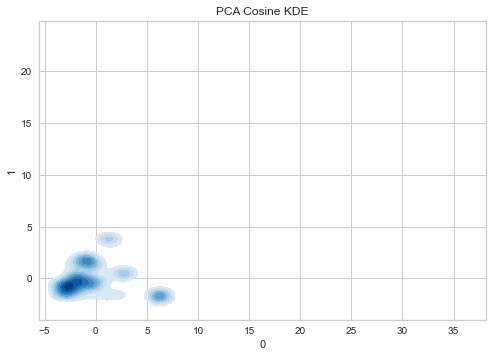

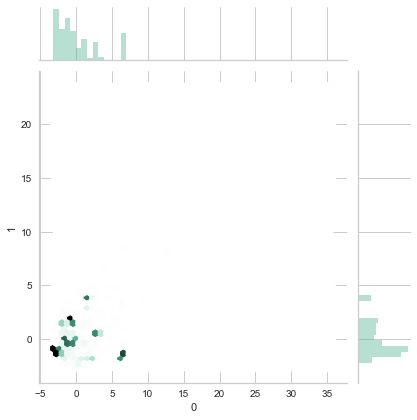

In [33]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(cosine) #replace with cosine or clust_df

PCA_components = pd.DataFrame(principalComponents)
PCA_components["Cluster"] = corpus["cluster"]
PCA_components["Jobclass"] = corpus["jobclass"]
PCA_components["Summary"] = corpus["Summary"]
PCA_components["Size"] = 1

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.kdeplot(PCA_components[0], PCA_components[1], shade=True, cmap = 'Blues',shade_lowest=False).set(title="PCA Cosine KDE")
ax = sns.jointplot(PCA_components[0], PCA_components[1], kind="hex", color="#4CB391")

## The PCA search and summarize function:

In [34]:
from gensim.summarization import summarize
from tqdm import tqdm

def area_search_function(x_min,x_max,y_min,y_max,df):
    summary = ""
    df_t = df[(df[0] > x_min) &
            (df[0] < x_max) &
            (df[1] > y_min) &
            (df[1] < y_max)]
    all_desc = df_t["Summary"]
    for desc in tqdm(all_desc):
        try:
            summary = summary + desc
        except:
            print(desc)
    return summary

# for k in range(0,true_k):
#     PCA_components_k=PCA_components[PCA_components["Cluster"]==k]

#     summary_pinpoint = area_search_function(-1,1,-0.5,-0.1,PCA_components_k)
#     summary_pinpoint = summarize(summary_pinpoint,word_count=200)
#     print('Cluster: {}'.format(k))
#     print(summary_pinpoint)
#     print('')

summary_pinpoint = area_search_function(-5,0,-3,3,PCA_components)
summary_pinpoint = summarize(summary_pinpoint,word_count=200)
print(summary_pinpoint)

100%|██████████| 2031/2031 [00:00<00:00, 71261.17it/s]


About you You have deep interests in customer and market behavior and methods to measure and anticipate it You are passionate about unveiling answers to most difficult questions using data and models You feel accomplished seeing your pricing recommendations being implemented while shopping for yourself You cant stop thinking about learning something new every day and enjoy being surrounded by highly talented people Key responsibilities Develop and apply statistical methods and experimentation to analyze the effect of pricing and sales decisions on business performance Collaborate with internal stakeholders to design and deploy pricing initiatives based upon analytical findings Present results and recommendations to relevant stakeholders, including senior leadership Requirements Must-haves At least  years working experience in data science, ideally in a consumer-focused setting Experience in designing, deploying, and analyzing in-market experiments and/or AB tests Ability to think creat

## Structured Extraction using spaCy

In [35]:
import spacy
import en_core_web_sm
from spacy import displacy

# load en_core_web_sm of English for vocabluary, syntax & entities
nlp = en_core_web_sm.load()

sentence= "This position will be the first of its kind at Fair Harbor and as such, the person in this role must be able and excited to take full responsibility for building out and maintaining internal tracking and reporting procedures"

processed_sentence = nlp(sentence)

displacy.render(processed_sentence, style="dep", jupyter= True)

ModuleNotFoundError: No module named 'spacy'

In [ ]:
displacy.render(processed_sentence, style = "ent",jupyter = True)

## Find entity pairs and relationships

In [ ]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

def get_entities(sent):
  # credit to https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

## Network Graph Visualization

In [ ]:
entity_pairs = []

#create list with all sentences
tokens = corpus["Summary"].apply(lambda x: sent_tokenize(x))
all_sent = []
for token in tokens:
    all_sent.extend(token)

for i in all_sent:
  entity_pairs.append(get_entities(i))

relations = [get_relation(i) for i in all_sent]

top_relations=pd.Series(relations).value_counts()

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Provide"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()